<center>

![huawei-logo](https://www-file.huawei.com/-/media/corporate/images/home/logo/huawei_logo.png)

<p><b>Летняя школа. "Современные методы теории информации, оптимизации и управления".</p></b>
Sirius-2020.
<center> <b>Авторы материала: к.т.н. Антонов Лев, Власов Роман.

# Практическое знакомство с AutoKeras
![autokeras-logo](https://camo.githubusercontent.com/5eedb6a5c3303767497912731e006b662bf83490/68747470733a2f2f6175746f6b657261732e636f6d2f696d672f726f775f7265642e737667)

In [1]:
!pip install git+https://github.com/keras-team/keras-tuner.git@1.0.2rc1  &> /dev/null
!pip install autokeras  &> /dev/null

## Image Classification. CIFAR10.

В этой тетради рассмотрим результаты использования библиотеки **AutoKeras** для стандартного набора **CIFAR_10**.

CIFAR-10 (Canadian Institute For Advanced Research) — является большим набором изображений, который обычно используется для тестирования алгоритмов машинного обучения. Он содержит 60 000 цветных картинок размером 32х32 пикселя, размеченных в один из десяти классов: самолеты, автомобили, коты, олени, собаки, лягушки, лошади, корабли и грузовики. В наборе данных по 6000 картинок каждого класса. CIFAR-10 является размеченным подмножеством заметно большего набора данных, состоящего примерно из восьмидесяти миллионов изображений.

In [ ]:
from tensorflow.keras.datasets import cifar10
import autokeras as ak
from autokeras import ImageClassifier
from tensorflow.keras.models import model_from_json
from sklearn.metrics import classification_report
import os
import numpy as np

In [ ]:
OUTPUT_PATH = "1_AutoMLArchSearchClassiferCIFAR10/"

Запустим синтез моделей в автоматическом режиме с одной попыткой запуска (max_trail = 1) и одной эпохой обучений (epochs = 1)

In [ ]:
# Загрузка данных
((trainX, trainY), (testX, testY)) = cifar10.load_data()
lable_names= ["airplane", "automobile", "bird", "cat", "deer",
              "dog", "frog", "horse", "ship", "truck"]

Y = np.asarray(trainY)
X = np.asarray(trainX)

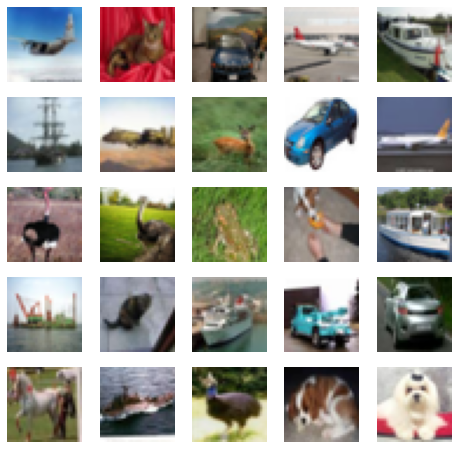

In [ ]:
import matplotlib.pyplot as plt
fig, axes1 = plt.subplots(5,5,figsize=(8,8))
for j in range(5):
    for k in range(5):
        i = np.random.choice(range(len(X)))
        axes1[j][k].set_axis_off()
        axes1[j][k].imshow(X[i:i+1][0])

Предоставим алгоритму полную свободу действий и выполним одну итерацию, чтобы оценить примерное качество на валидации.

In [ ]:
import tensorflow as tf

clf = ImageClassifier(max_trials=1, directory  = OUTPUT_PATH, overwrite  = True,)
clf.fit(x=X, y=Y, validation_split=0.2, epochs=3, batch_size=64)

Trial 1 Complete [00h 00m 31s]
val_loss: 0.9529722929000854

Best val_loss So Far: 0.9529722929000854
Total elapsed time: 00h 00m 31s
INFO:tensorflow:Oracle triggered exit
Epoch 1/3
782/782 [==============================] - 8s 10ms/step - loss: 1.3969 - accuracy: 0.5074
Epoch 2/3
782/782 [==============================] - 8s 10ms/step - loss: 1.0689 - accuracy: 0.6261
Epoch 3/3
782/782 [==============================] - 8s 10ms/step - loss: 0.9707 - accuracy: 0.6588


In [ ]:
model = clf.export_model()
predicted = model.predict(testX)
report = classification_report(testY, np.argmax(predicted, 1), target_names=lable_names)
print(report)

              precision    recall  f1-score   support

    airplane       0.70      0.73      0.71      1000
  automobile       0.73      0.87      0.79      1000
        bird       0.58      0.51      0.55      1000
         cat       0.47      0.56      0.51      1000
        deer       0.68      0.58      0.63      1000
         dog       0.62      0.59      0.61      1000
        frog       0.75      0.81      0.78      1000
       horse       0.73      0.76      0.74      1000
        ship       0.80      0.73      0.76      1000
       truck       0.81      0.70      0.75      1000

    accuracy                           0.68     10000
   macro avg       0.69      0.68      0.68     10000
weighted avg       0.69      0.68      0.68     10000



In [ ]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
normalization (Normalization (None, 32, 32, 3)         7         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 12544)            

Экспериментально замечено, что если мы устанавливаем параметр **max_trail** (количество синтезируемых моделей) больше 1, то на второй попытке поиска без ограничений, алгоритм, понимая, что решается задача классификации изображений, начинает использовать блоки типа **resnetBlokc**, **XceptionBlock**, фактичекски вставляя эти архитектуры целиком в синтезируемую модель и пытаясь "тюнить" параметры как самой подсети **resnet**, так и всей синтезируемой модели в целом. Если **max_trail = 1**, то тогда алгоритм использует только **DenseBlock** для синтеза моделей.
Использование алгоритмом блоков **resnetBlokc** значительно замедляет процесс обучения, так как эта архитектура содержит большое число параметров и каждая эпоха обучения модели выполняется намного медленнее.

Запустим синтез моделей в автоматическом режиме с тремя попытками запуска (max_trail = 3), но количество эпох обучений установим равным 10 (epochs = 10)

In [ ]:
clf_10 = ImageClassifier(max_trials=2, directory  = OUTPUT_PATH, overwrite  = True,)
clf_10.fit(x=X, y=Y, validation_split=0.2, epochs=3, batch_size=64)

Trial 2 Complete [00h 42m 56s]
val_loss: 0.2060825079679489

Best val_loss So Far: 0.2060825079679489
Total elapsed time: 00h 43m 33s
INFO:tensorflow:Oracle triggered exit
Epoch 1/3
782/782 [==============================] - 983s 1s/step - loss: 0.8170 - accuracy: 0.7267
Epoch 2/3
782/782 [==============================] - 981s 1s/step - loss: 0.3101 - accuracy: 0.8965
Epoch 3/3
782/782 [==============================] - 981s 1s/step - loss: 0.2140 - accuracy: 0.9293


In [ ]:
model_10 = clf_10.export_model()
predicted_10 = model_10.predict(testX)
report = classification_report(testY, np.argmax(predicted_10, 1), target_names=lable_names)
print(report)

              precision    recall  f1-score   support

    airplane       0.93      0.96      0.94      1000
  automobile       0.97      0.94      0.96      1000
        bird       0.93      0.91      0.92      1000
         cat       0.87      0.86      0.87      1000
        deer       0.95      0.90      0.92      1000
         dog       0.92      0.89      0.90      1000
        frog       0.93      0.97      0.95      1000
       horse       0.95      0.96      0.95      1000
        ship       0.96      0.96      0.96      1000
       truck       0.92      0.97      0.95      1000

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000



In [ ]:
model_10.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
normalization (Normalization (None, 32, 32, 3)         7         
_________________________________________________________________
random_translation (RandomTr (None, 32, 32, 3)         0         
_________________________________________________________________
random_flip (RandomFlip)     (None, 32, 32, 3)         0         
_________________________________________________________________
resizing (Resizing)          (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50 (Model)             multiple                  23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0     

Запустим синтез моделей в автоматическом режиме 3 попытки запуска (max_trail = 3), количество эпох обучений установим равным 10 (epochs = 10)

In [ ]:
clf_30 = ImageClassifier(max_trials = 3, directory  = OUTPUT_PATH, overwrite = True)
clf_30.fit(x = X, y = Y, validation_split = 0.2, epochs = 10, batch_size = 64)

Trial 3 Complete [00h 14m 01s]
val_loss: 1.6285399198532104

Best val_loss So Far: 0.17536120116710663
Total elapsed time: 02h 34m 29s
INFO:tensorflow:Oracle triggered exit
Epoch 1/10
782/782 [==============================] - 959s 1s/step - loss: 0.8486 - accuracy: 0.7170
Epoch 2/10
782/782 [==============================] - 964s 1s/step - loss: 0.3214 - accuracy: 0.8919
Epoch 3/10
782/782 [==============================] - 961s 1s/step - loss: 0.2167 - accuracy: 0.9268
Epoch 4/10
782/782 [==============================] - 961s 1s/step - loss: 0.1592 - accuracy: 0.9459
Epoch 5/10
782/782 [==============================] - 961s 1s/step - loss: 0.1193 - accuracy: 0.9602
Epoch 6/10
782/782 [==============================] - 962s 1s/step - loss: 0.0890 - accuracy: 0.9712
Epoch 7/10
782/782 [==============================] - 961s 1s/step - loss: 0.0646 - accuracy: 0.9788
Epoch 8/10
782/782 [==============================] - 960s 1s/step - loss: 0.0487 - accuracy: 0.9848
Epoch 9/10
782/782 

In [ ]:
model_30 = clf_30.export_model()
predicted_30 = model_30.predict(testX)
report = classification_report(testY, np.argmax(predicted_30, 1), target_names=lable_names)
print(report)

              precision    recall  f1-score   support

    airplane       0.97      0.97      0.97      1000
  automobile       0.97      0.97      0.97      1000
        bird       0.97      0.94      0.95      1000
         cat       0.90      0.91      0.91      1000
        deer       0.94      0.96      0.95      1000
         dog       0.92      0.91      0.91      1000
        frog       0.96      0.98      0.97      1000
       horse       0.98      0.97      0.98      1000
        ship       0.97      0.97      0.97      1000
       truck       0.97      0.96      0.97      1000

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000



In [ ]:
model_30.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
normalization (Normalization (None, 32, 32, 3)         7         
_________________________________________________________________
random_translation (RandomTr (None, 32, 32, 3)         0         
_________________________________________________________________
random_flip (RandomFlip)     (None, 32, 32, 3)         0         
_________________________________________________________________
resizing (Resizing)          (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50 (Model)             multiple                  23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0     

Обратите внимание, на то как выросло время работы алгоритма при установке параметра **max_trials** равным > 1.

Резюмируем результаты классификации:

| Значение параметров        | Результаты (macro avg) |Время архитектурного поиска|
| :-------------------------  | ---------------------- | --------- |
| max_trials = 1, epochs = 3 | 0.69                   |00h 00m 31s|
| max_trials = 2, epochs = 3 | 0.93                   |00h 43m 33s|
| max_trials = 3, epochs = 10| **0.96**               |**02h 34m 29s**|